In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [4]:
class_names = ['glioma', 'menin', 'tumor']

In [ ]:
image_data = np.load('image_data.npy')
image_labels = np.load('image_labels.npy')

# update shape to match PyTorch's format (Examples, Channels, Height, Width)
updated_image_data_temp = np.swapaxes(image_data, 1, 3)
updated_image_data = np.swapaxes(updated_image_data_temp, 2, 3)

print('Orginal shape: ', image_data.shape)
print('New shape: ', updated_image_data.shape)

(6056, 256, 256, 3)
(6056, 3, 256, 256)


In [ ]:
model = nn.Sequential(
    # input layer
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),

    # first conv layer
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5), # 32 --> 32 channels (input layer)
    nn.ReLU(),
    nn.BatchNorm2d(32), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2
    nn.Dropout2d(0.1), # remove 10% for regularization

    # second conv layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 32 --> 64
    nn.ReLU(), # activation
    nn.BatchNorm2d(64), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2 frames
    nn.Dropout2d(0.2), # remove 20% for regularization

    nn.AdaptiveAvgPool2d((4, 4)), # Avg pooling into 4x4 to reduce size
    
    nn.Flatten(), # force to 1D
    nn.Linear(64*16, 128), # fully connected layer
    nn.ReLU(), # activation
    nn.Dropout(0.5), # remove 10% for regularization

    nn.Linear(128, len(class_names)) # Prediction Layer
)

# set to GPU for acceleration
mps_device = torch.device("mps")
model.to(mps_device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (2): ReLU()
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Dropout2d(p=0.1, inplace=False)
  (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Dropout2d(p=0.2, inplace=False)
  (11): AdaptiveAvgPool2d(output_size=(4, 4))
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=1024, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
# class for custom dataset needed for pytorch 
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# create train test splits
x_train, x_test, y_train, y_test = train_test_split(updated_image_data, image_labels, test_size=0.2, random_state=13, shuffle=True)

# ecode labels numerically
label_encoder = LabelEncoder() 
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# create custom dataset objects for train and test sets
train_set = CustomDataset(x_train, y_train)
test_set = CustomDataset(x_test, y_test)



In [ ]:
# create loaders for batches
training_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False)

# set loss and opimizer functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [ ]:
# code for training on single epoch 
def train_single_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    total_loss = 0.0  # Track total for the entire epoch
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        
        # Zero gradients
        optimizer.zero_grad()

        # Make predictions
        outputs = model(inputs)

        # Compute loss and gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Accumulate losses
        batch_loss = loss.item()
        running_loss += batch_loss
        total_loss += batch_loss * inputs.size(0)  # Scale by batch size
        
        # Report every 1000 batches
        if i % 1000 == 999:
            avg_loss = running_loss / 1000
            print('  batch {} loss: {:.4f}'.format(i + 1, avg_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', avg_loss, tb_x)
            running_loss = 0.0  # ← RESET after reporting!
    
    # Return average loss for entire epoch
    epoch_loss = total_loss / len(training_loader.dataset)
    return epoch_loss

In [ ]:
# TRAINING LOOP!
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

EPOCHS = 30
best_vloss = 1_000_000.

true_labels_list = []
predicted_labels_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number +1))

    model.train(True)
    avg_loss = train_single_epoch(epoch_number, writer)

    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(mps_device)
            vlabels = vlabels.to(mps_device)
            voutputs = model(vinputs)
            _, predicted = torch.max(voutputs, 1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

            true_labels_list.extend(vlabels.cpu().numpy())
            predicted_labels_list.extend(predicted.cpu().numpy())

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    val_loss_list.append(avg_vloss)
    train_loss_list.append(avg_loss)

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss, 'Validation' : avg_vloss},
                       epoch_number + 1)
    
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1


EPOCH 1:
LOSS train 0.5237863717137734 valid 0.948228120803833
EPOCH 2:
LOSS train 0.5048740448708577 valid 0.3922371566295624
EPOCH 3:
LOSS train 0.4692926112359388 valid 0.3568919897079468
EPOCH 4:
LOSS train 0.44162461136696163 valid 0.3573992848396301
EPOCH 5:
LOSS train 0.41336036571028506 valid 0.5186653733253479
EPOCH 6:
LOSS train 0.40057156005801986 valid 0.3600141108036041
EPOCH 7:
LOSS train 0.3876781261423764 valid 0.2950305938720703
EPOCH 8:
LOSS train 0.36166112607654144 valid 0.4039685130119324
EPOCH 9:
LOSS train 0.33800345605268495 valid 0.26101475954055786
EPOCH 10:
LOSS train 0.32243950699219937 valid 0.2410694807767868
EPOCH 11:
LOSS train 0.3157015665858049 valid 0.22630400955677032
EPOCH 12:
LOSS train 0.28685707190557763 valid 0.27530792355537415
EPOCH 13:
LOSS train 0.27670933930034125 valid 0.2463875412940979
EPOCH 14:
LOSS train 0.25933974786141684 valid 0.19251208007335663
EPOCH 15:
LOSS train 0.25157143528943127 valid 0.1978900283575058
EPOCH 16:
LOSS train 

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     12150
         1.0       0.85      0.89      0.87     12150
         2.0       0.93      0.93      0.93     12060

    accuracy                           0.91     36360
   macro avg       0.91      0.91      0.91     36360
weighted avg       0.91      0.91      0.91     36360



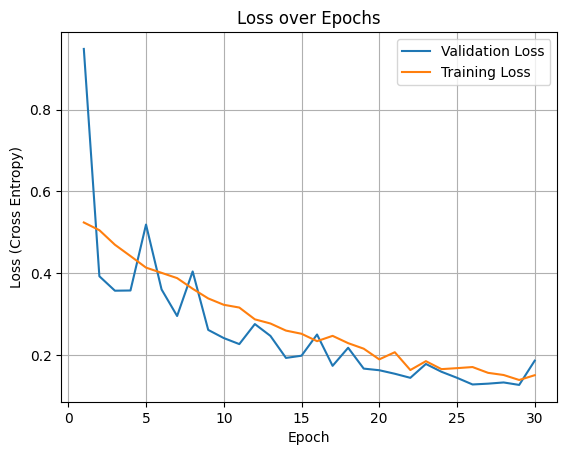

In [147]:
class_report = metrics.classification_report(true_labels_list, predicted_labels_list)
print(class_report)

val_losses = []
for loss in val_loss_list:
    val_losses.append(loss.cpu())



plt.figure(1, clear=True)
plt.plot(np.arange(epoch_number)+1, val_losses, label='Validation Loss')
plt.plot(np.arange(epoch_number)+1, train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()